In [2]:
import os
import csv
import argparse
import requests
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms as tfm
import torch.nn.functional as F
import time
import glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import shutil
import kagglehub
import matplotlib.pyplot as plt


In [3]:
# Download the 'osv-mini-129k' dataset from Kaggle using kagglehub.
path = kagglehub.dataset_download("josht000/osv-mini-129k")
print("Path to dataset files:", path)

100%|██████████| 5.63G/5.63G [00:51<00:00, 117MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/josht000/osv-mini-129k/versions/1


In [ ]:
def download_file_robust(url, filename):
    """Downloads a file in chunks to prevent corruption/timeouts."""
    # Check if the file already exists. If it's a model (pth.tar) and too small, re-download.
    if os.path.exists(filename):
        if "pth.tar" in filename and os.path.getsize(filename) < 90 * 1024 * 1024:
            print(f"File {filename} looks corrupt (too small). Re-downloading...")
            os.remove(filename)
        else:
            return  # File exists and looks okay, skip download

    print(f"Downloading {filename}...")
    try:
        response = requests.get(url, stream=True) # Make a streaming GET request
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        total_size = int(response.headers.get('content-length', 0)) # Get total file size from headers

        # Download file in chunks with a progress bar
        with open(filename, "wb") as file, tqdm(
            desc=filename,
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                bar.update(size)
        print("Download complete.")
    except Exception as e:
        print(f"Download failed: {e}")
        # Clean up partial file if download fails
        if os.path.exists(filename):
            os.remove(filename)
        exit()

def download_scene_hierarchy_file():
    """Downloads the scene hierarchy CSV file from Google Docs."""
    url = 'https://docs.google.com/spreadsheet/ccc?key=1H7ADoEIGgbF_eXh9kcJjCs5j_r3VJwke4nebhkdzksg&output=csv'
    # We download to a temp file first to ensure we don't write error messages into the CSV (Original comment, kept for context)
    try:
        response = requests.get(url, timeout=10) # Make a GET request with a timeout
        response.raise_for_status() # Raise an HTTPError for bad responses
        # Write the downloaded content to a CSV file
        with open("scene_hierarchy_places365.csv", "w", encoding='utf-8') as file:
            file.write(response.content.decode('utf-8') + "\n")
    except Exception as e:
        print(f"Error downloading hierarchy CSV: {e}")
        exit()

def download_pretrained_on_places(model_name="resnet50"):
    """Downloads a pre-trained Places365 model (ResNet50 or ResNet152)."""
    url = f'http://places2.csail.mit.edu/models_places365/{model_name}_places365.pth.tar'
    download_file_robust(url, f"{model_name}_places365.pth.tar")

In [ ]:
class SceneClassifier(torch.nn.Module):
    """A PyTorch module for classifying scenes into Indoor, Natural, or Urban categories."""
    def __init__(self, scene_hierarchy_file='scene_hierarchy_places365.csv', model_name="resnet50"):
        super().__init__()

        # Define the device
        # Automatically detect and use CUDA (GPU) if available, otherwise use CPU.
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using Device: {self.device}")

        assert model_name in ["resnet50", "resnet152"], f"model_name is {model_name}"

        # Download scene hierarchy CSV and pre-trained model if they don't exist
        if not os.path.exists(scene_hierarchy_file):
            download_scene_hierarchy_file()
        if not os.path.exists(f"{model_name}_places365.pth.tar"):
            download_pretrained_on_places(model_name)

        # Load Hierarchy: Read the scene hierarchy for Places365 dataset
        print('Loading scene hierarchy ...')
        hierarchy_places3 = []
        with open(scene_hierarchy_file, 'r', encoding='utf-8') as csvfile:
            content = csv.reader(csvfile, delimiter=',')
            next(content); next(content) # Skip header rows
            for line in content:
                hierarchy_places3.append(line[1:4]) # Extract relevant columns

        # Convert hierarchy to a NumPy array and normalize rows to sum to 1
        hierarchy_places3 = np.asarray(hierarchy_places3, dtype=float)
        sum_rows = np.sum(hierarchy_places3, axis=1)
        sum_rows[sum_rows == 0] = 1.0 # Avoid division by zero
        self.hierarchy_places3 = hierarchy_places3 / np.expand_dims(sum_rows, axis=-1)

        # Load Model: Initialize a ResNet model and load pre-trained weights
        print(f'Loading {model_name}...')
        self.model = torchvision.models.resnet50(weights=None) # Initialize ResNet without default weights
        # Replace the final fully connected layer to match the 365 classes of Places365
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, 365)

        # Load state dictionary from the downloaded checkpoint
        checkpoint = torch.load(f"{model_name}_places365.pth.tar", map_location='cpu')
        # Remove 'module.' prefix from keys if present (due to DataParallel training)
        state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
        self.model.load_state_dict(state_dict)

        # Move the model to the GPU
        # Transfer the entire model to the selected device
        self.model.to(self.device)
        self.model.eval() # Set the model to evaluation mode (disables dropout, batchnorm updates)

        # Define image transformation pipeline
        self.transform = tfm.Compose([
            tfm.Resize((256, 256)), # Resize images to 256x256
            tfm.CenterCrop(224), # Crop the center to 224x224 (standard input size for ResNet)
            tfm.ToTensor(), # Convert PIL Image to PyTorch Tensor
            tfm.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # Normalize with ImageNet mean/std
        ])

    def process_images(self, images_paths):
        """Loads images, applies transformations, and performs scene classification."""
        pil_images = [Image.open(p).convert('RGB') for p in images_paths] # Open images as PIL RGB
        batch = [self.transform(p) for p in pil_images] # Apply transformations to each image
        batch = torch.stack(batch) # Stack individual tensors into a batch tensor

        # Move input data to the GPU
        # Transfer the input batch to the selected device (GPU or CPU)
        batch = batch.to(self.device)

        return self(batch) # Call the forward method for classification

    def forward(self, batch):
        """Performs the forward pass for scene classification."""
        with torch.inference_mode(): # Disable gradient calculation for faster inference
            logits = self.model(batch) # Get raw model outputs (logits)

            # Move result back to CPU for NumPy
            # Apply softmax to get probabilities, then move to CPU and convert to NumPy array
            scene_probs = F.softmax(logits, dim=1).cpu().numpy()

            # Matrix multiplication happens on CPU (fast enough for small matrices)
            # Multiply scene probabilities by the hierarchy to get Indoor/Natural/Urban probabilities
            places_prob = np.matmul(scene_probs, self.hierarchy_places3)
            scene_label_int = np.argmax(places_prob, axis=1) # Get the index of the highest probability

        return scene_label_int.tolist() # Return the predicted scene labels as a list of integers

    def label_int_to_str(self, scene_label_int):
        """Converts integer scene labels to human-readable strings."""
        if scene_label_int == 0: return 'Indoor'
        elif scene_label_int == 1: return 'Natural'
        elif scene_label_int == 2: return 'Urban'
        return 'Unknown'


def parse_args():
    """Parses command-line arguments (not used in this notebook's main flow)."""
    parser = argparse.ArgumentParser(description='Scene Classifier')
    parser.add_argument('--image_path', type=str, required=True, help='Path to image file')
    args = parser.parse_args()
    return args

In [ ]:
# 1. Custom Dataset for parallel loading
class SceneDataset(Dataset):
    """Custom PyTorch Dataset for loading images and applying transformations."""
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths # List of image file paths
        self.transform = transform # Image transformation pipeline

    def __len__(self):
        """Returns the total number of images in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Loads and transforms an image given its index."""
        path = self.image_paths[idx]
        try:
            # Load image and convert to RGB
            img = Image.open(path).convert('RGB')
            if self.transform:
                img = self.transform(img) # Apply transformations
            return img, path # Return transformed image and its original path
        except Exception as e:
            # Handle corrupted images by returning None and the path
            # This allows the collate_fn to skip problematic images.
            return None, path

def collate_fn(batch):
    """Removes incorrectly loaded images from a batch before stacking."""
    # Filter out any (None, path) tuples from the batch (i.e., corrupted images)
    batch = list(filter(lambda x: x[0] is not None, batch))
    if len(batch) == 0: return torch.tensor([]), [] # Return empty tensors if batch is empty
    # Use default collate function for the remaining valid items
    return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
# Total time 15:20
if __name__ == '__main__':
    # CONFIGURATION
    # Define the base path where the dataset is expected to be located.
    base_path = "/root/.cache/kagglehub/datasets/josht000/osv-mini-129k/versions/1"
    batch_size = 64  # Number of images processed together by the GPU
    # Number of CPU cores that load images in parallel (Colab Free has 2 cores)
    num_workers = 2

    # Check if the specified base path exists. If not, prompt the user to ensure data is copied.
    if not os.path.exists(base_path):
        print("Local folder not found. Please run the copy block (shutil) first.")
    else:
        # 1. Initialize the classifier
        print("Initializing model...")
        classifier = SceneClassifier()

        # 2. Collect all image paths
        print("Searching for images...")
        # Use glob to find all image files (jpg, jpeg, png) recursively within the base_path.
        image_files = glob.glob(os.path.join(base_path, "**", "*.jpg"), recursive=True) + \
                      glob.glob(os.path.join(base_path, "**", "*.jpeg"), recursive=True) + \
                      glob.glob(os.path.join(base_path, "**", "*.png"), recursive=True)

        print(f"Found {len(image_files)} images.")

        # 3. Configure the DataLoader
        # Create an instance of the custom SceneDataset with the found image paths and classifier's transformations.
        dataset = SceneDataset(image_files, transform=classifier.transform)
        # Create a DataLoader for efficient and parallel loading of image batches.
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,     # Speeds up data transfer from CPU to GPU
            collate_fn=collate_fn, # Custom collate function to handle corrupted images
            shuffle=False # Shuffling is not necessary for inference
        )

        results = []
        start_time = time.time()

        # 4. High-performance prediction loop
        print(f"Starting classification with {num_workers} workers...")

        # Disable gradient calculations for faster inference and reduced memory consumption.
        with torch.inference_mode(): # Faster than no_grad
            # Iterate over batches of images provided by the DataLoader with a progress bar.
            for imgs, paths in tqdm(dataloader):
                if imgs.nelement() == 0: continue # Skip processing if the batch is empty

                # Move the entire batch of images to the GPU in a single operation.
                imgs = imgs.to(classifier.device) # Move the entire batch to the GPU at once

                # Perform simultaneous predictions on the batch of images.
                logits = classifier.model(imgs) # Get raw model outputs (logits).
                # Apply softmax to convert logits into probability distributions, then move to CPU and convert to NumPy array.
                probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

                # Matrix multiplication for hierarchy (Indoor/Natural/Urban)
                # Apply the scene hierarchy weights to the probabilities to get higher-level category predictions.
                # This NumPy operation is instantaneous for an entire batch
                places_probs = np.matmul(probs, classifier.hierarchy_places3)
                # Get the index of the highest probability, which corresponds to the predicted scene label.
                preds = np.argmax(places_probs, axis=1)

                # Store the results for each image in the current batch.
                for path, pred_idx in zip(paths, preds):
                    results.append({
                        'filename': os.path.splitext(os.path.basename(path))[0],
                        'true_label': os.path.basename(os.path.dirname(path)),
                        'predicted_label': classifier.label_int_to_str(pred_idx)
                    })

        # 5. Final Report
        elapsed = time.time() - start_time
        df = pd.DataFrame(results)

        print("\n" + "="*40)
        print("PROCESS COMPLETED")
        print(f"Total images: {len(df)}")
        print(f"Total time: {elapsed:.2f}s")
        print(f"Average speed: {len(df)/elapsed:.2f} images/sec")
        print("="*40)

        # Save the final results DataFrame to a CSV file in Google Drive.
        #df.to_csv("/content/drive/MyDrive/osv5m/result_final_classification.csv", index=False)
        #print("Results saved to Google Drive.")

🔧 Inizializzazione modello...
Using Device: cuda
Loading scene hierarchy ...
Loading resnet50...
🔍 Ricerca immagini in corso...
✅ Trovate 129118 immagini.
🚀 Avvio classificazione con 2 workers...


100%|██████████| 2018/2018 [15:20<00:00,  2.19it/s]



🏁 PROCESSO COMPLETATO
Immagini totali: 129118
Tempo totale: 920.65s
Velocità media: 140.25 immagini/sec
💾 Risultati salvati su Google Drive.


In [ ]:
#Mergin the obtain dataset on the original ones containing the ground truth
#united_csv_path = "/content/drive/MyDrive/osv5m/result_final_classification.csv"
original_train_csv = "/content/drive/MyDrive/osv5m/train_mini.csv"
original_test_csv  = "/content/drive/MyDrive/osv5m/test_mini.csv"

print("Loading results...")
#df_united = pd.read_csv(united_csv_path)
df_united = df
df_united.columns = df_united.columns.str.strip()

# Define our key column for the predictions file
UNITED_COL = 'filename'
df_united[UNITED_COL] = df_united[UNITED_COL].astype(str)

def update_original_file(original_path, output_name):
    if not os.path.exists(original_path):
        print(f"File not found: {original_path}")
        return

    # Load the Original File
    df_orig = pd.read_csv(original_path)
    df_orig.columns = df_orig.columns.str.strip()

    # Define our key column for the original file
    ORIG_COL = 'id'

    if ORIG_COL not in df_orig.columns:
        print(f"Error: '{ORIG_COL}' not found in {original_path}. Found: {df_orig.columns.tolist()}")
        return

    # Clean the 'id' column
    df_orig[ORIG_COL] = df_orig[ORIG_COL].astype(str).str.replace(r'\.(jpg|jpeg|png)$', '', regex=True)

    # Perform the Merge
    # We join df_orig (Left) and df_united (Right)
    updated_df = pd.merge(
        df_orig,
        df_united[[UNITED_COL, 'predicted_label']],
        left_on=ORIG_COL,
        right_on=UNITED_COL,
        how='left'
    )

    # Cleanup
    if UNITED_COL in updated_df.columns and UNITED_COL != ORIG_COL:
        updated_df = updated_df.drop(columns=[UNITED_COL])

    # Save
    output_path = os.path.join(os.path.dirname(original_path), output_name)
    updated_df.to_csv(output_path, index=False)
    print(f"Successfully created: {output_name}")


update_original_file(original_train_csv, "train_with_predictions.csv")
update_original_file(original_test_csv, "test_with_predictions.csv")

Loading results...
✅ Successfully created: train_with_predictions.csv
✅ Successfully created: test_with_predictions.csv


In [ ]:
#Check the dataset
files_to_check = [
    "/content/drive/MyDrive/osv5m/train_with_predictions.csv",
    "/content/drive/MyDrive/osv5m/test_with_predictions.csv"
]

for file_path in files_to_check:
    if not os.path.exists(file_path):
        continue

    print(f"\n--- Diagnostic Report: {os.path.basename(file_path)} ---")
    df = pd.read_csv(file_path)

    # Check for NA values in the prediction column
    na_count = df['predicted_label'].isna().sum()
    if na_count > 0:
        print(f"Found {na_count} images with NO prediction (NA).")
    else:
        print("No missing values (NA) found.")

    # Check for unexpected labels
    counts = df['predicted_label'].value_counts(dropna=False)
    print("\nLabel Distribution:")
    print(counts)

    # Identify "Strange" values
    valid_labels = ['Natural', 'Urban', 'Indoor']
    actual_labels = df['predicted_label'].dropna().unique()
    strange_values = [L for L in actual_labels if L not in valid_labels]

    if len(strange_values) > 0:
        print(f"STRANGE VALUES FOUND: {strange_values}")
    else:
        print("All labels are valid (Natural/Urban/Indoor).")


--- 📊 Diagnostic Report: train_with_predictions.csv ---
✅ No missing values (NA) found.

Label Distribution:
predicted_label
Natural    84096
Urban      34570
Indoor       342
Name: count, dtype: int64
✅ All labels are valid (Natural/Urban/Indoor).

--- 📊 Diagnostic Report: test_with_predictions.csv ---
✅ No missing values (NA) found.

Label Distribution:
predicted_label
Natural    9556
Urban       520
Indoor       34
Name: count, dtype: int64
✅ All labels are valid (Natural/Urban/Indoor).


In [ ]:
import os
import glob

# Search recursively for the first jpg to find the real directory
kaggle_path = "/root/.cache/kagglehub/datasets/josht000/osv-mini-129k/versions/1"
sample_jpgs = glob.glob(os.path.join(kaggle_path, "**", "*.jpg"), recursive=True)

if sample_jpgs:
    # This is the real folder containing your images
    actual_image_dir = os.path.dirname(sample_jpgs[0])
    print(f"Found images in: {actual_image_dir}")
else:
    print("No images found. Check if the dataset downloaded correctly.")

✅ Found images in: /root/.cache/kagglehub/datasets/josht000/osv-mini-129k/versions/1/osv5m/train_images/New Mexico


🔍 Mapping dataset images...
✅ Indexed 129118 images from disk.


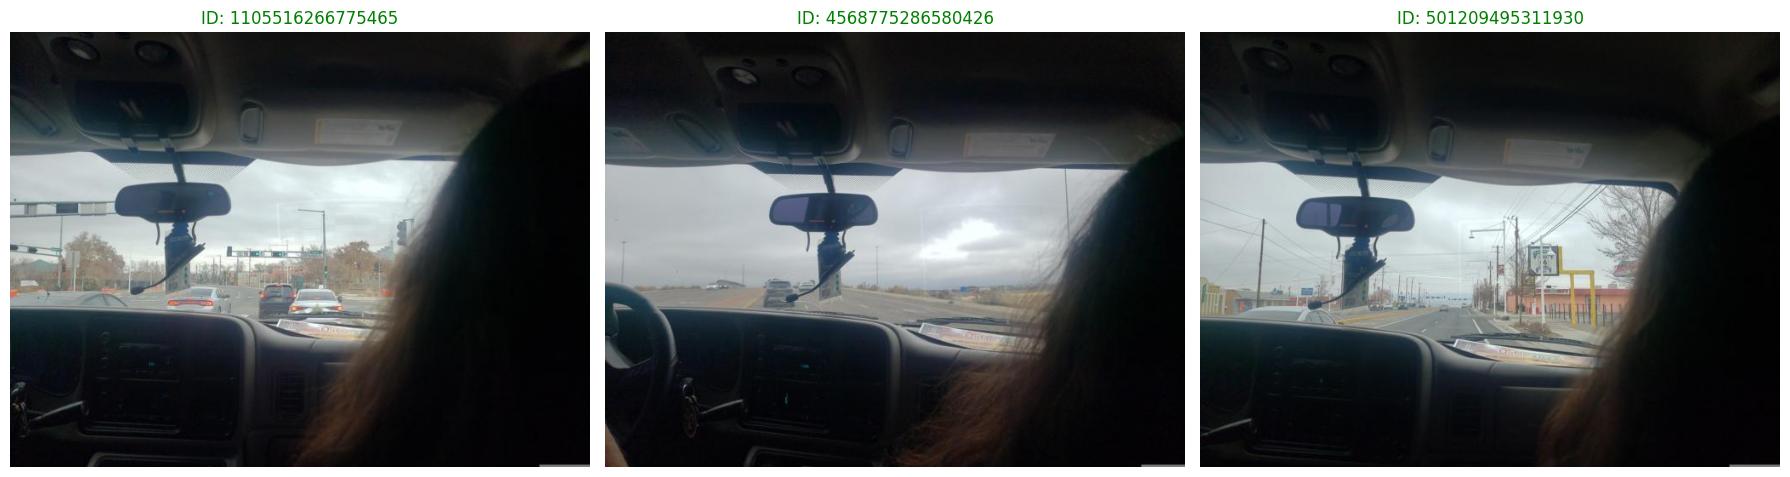

In [ ]:
#Checking the indoor category

# 1. Automatic Path Detection
# This finds every .jpg inside the Kaggle cache so we don't have to guess the folder
kaggle_root = "/root/.cache/kagglehub/datasets/josht000/osv-mini-129k/versions/1"
print("Mapping dataset images...")
all_image_paths = {os.path.basename(p): p for p in glob.glob(os.path.join(kaggle_root, "**", "*.jpg"), recursive=True)}
print(f"Indexed {len(all_image_paths)} images from disk.")

# 2. Filter Dataset
indoor_df = df[df['predicted_label'] == 'Indoor'].reset_index(drop=True)

def show_all_indoor(dataframe, limit=30):
    """
    Plots images in rows of 3.
    limit: set to a high number to see more images (careful with Colab memory!)
    """
    count = min(len(dataframe), limit)
    rows = (count + 2) // 3

    plt.figure(figsize=(18, 5 * rows))

    for i in range(count):
        row = dataframe.iloc[i]
        img_id = str(row['id'])

        # Ensure we check for the filename with .jpg extension
        filename = img_id if img_id.endswith('.jpg') else f"{img_id}.jpg"

        plt.subplot(rows, 3, i + 1)

        # Use our pre-mapped paths to find the file instantly
        if filename in all_image_paths:
            img_path = all_image_paths[filename]
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"ID: {img_id}", fontsize=12, color='green')
        else:
            plt.text(0.5, 0.5, f"Missing on Disk:\n{filename}",
                     ha='center', va='center', color='red', fontsize=10)
            plt.title(f"ID: {img_id} (Not Found)", color='red')

        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Adjust limit to see more or fewer images (limit up to 342)
show_all_indoor(indoor_df, limit=3)